In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
fits_filename = ('/Users/orion/phd_research/3C297/finalcube_3C297_mediansubtracted.fits')     
hdul = fits.open(fits_filename)
hdul.info()
data_cube = hdul[0].data
cube_header = hdul[0].header 

print (np.shape(data_cube))

Filename: /Users/orion/phd_research/3C297/0final_3C297_medsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     779   (66, 68, 2210)   float32   
(2210, 68, 66)


In [3]:
cw = cube_header['CRVAL3']         
mp = cube_header['CDELT3']       

print (cw,mp)

#y = data_cube[:,33,33]

summed = np.arange(len(data_cube), dtype=float)
summed = 0
for i in range(32,35):
    for j in range(32,35):
        print (i,j)
        summed += data_cube[:,i,j]

print (np.shape(summed))

y = summed 
x = np.arange(len(y))
start_w = cw - cube_header['CRPIX3']*mp 
x = start_w + x*mp

x    

1.64999997615814 0.000195000000530854
32 32
32 33
32 34
33 32
33 33
33 34
34 32
34 33
34 34
(2210,)


array([1.43452498, 1.43471998, 1.43491498, ..., 1.86488998, 1.86508498,
       1.86527998])

In [5]:
y[np.isnan(y)] = 1e-15
#wo_err[np.isnan(wo_err)] = 0.000001
y[y>5000] = 1e-15
y[y<-500] = 1e-15

2.40915


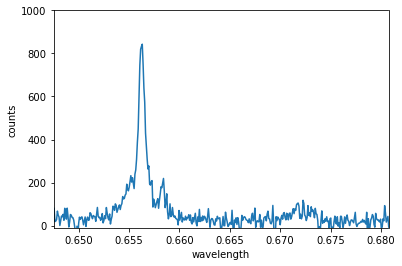

In [6]:
z = 1.40915   #spectroscopic redshift
k = 1+z
print (k)

plt.plot(x/k,y) 
plt.xlim([1.560/k,1.640/k])            
plt.ylim([-10,1000])
plt.xlabel('wavelength')
plt.ylabel('counts')     
plt.show()

[5954.48592064 5955.29533475 5956.10474886 ... 7740.86286343 7741.67227754
 7742.48169165]
[1.43452498 1.43471998 1.43491498 ... 1.86488998 1.86508498 1.86527998]


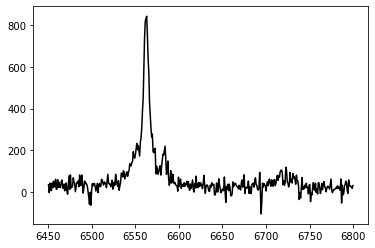

In [7]:
wave = (x/k)*10000 
print (wave)

select = (wave>6450) & (wave<6800)
small_wave = wave[select]
small_spec = y[select]

print (x)
plt.plot(small_wave,small_spec,'k-')

(2210, 68, 66)


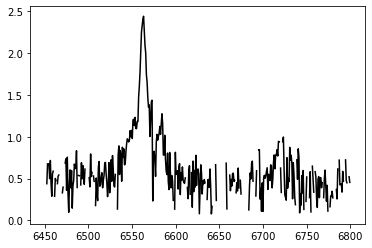

In [8]:
error_cube = ('/Users/orion/phd_research/3C297/line_fitting/3x3spaxel_error_cube.fits')  

hdul2 = fits.open(error_cube)

d_error = hdul2[0].data
print (np.shape(d_error))

stderror = d_error[:,33,33]
error_spec = stderror[select]
plt.plot(small_wave,error_spec,'k-')

In [ ]:
# Using Gaussian convolution to get rid of nan(s) by smoothing the error spectrum

from astropy.convolution import Gaussian1DKernel, convolve

gauss = Gaussian1DKernel(stddev=2)
err_spec_temp = convolve(error_spec, gauss)

In [12]:
select_cont = (small_wave>6650)&(small_wave<6680)

flux_cont = np.std(small_spec[select_cont])
flux_err = np.mean(err_spec_temp[select_cont])

b = flux_cont/flux_err
print (b)

err_spec = b*err_spec_temp

50.50634


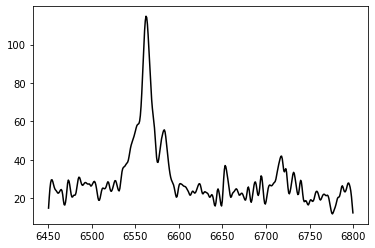

In [14]:
plt.plot(small_wave,err_spec,'k-')

In [13]:
def redshift(vel):
    return vel/300000.0 

def line_width(vel_sigma,rest_line,inst_res_fwhm=0.0): 
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2) 

In [14]:
def gauss(wave_range,amplitude,vel,vel_sigma,rest_w):
    line = (amplitude)*exp(-(wave_range-(rest_w*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_w))**2))
    return line


def full_gauss_residual(params,wave_range,data,error):
    (amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c) = params
    
    SII_6716 = gauss(wave_range,amp_SII6716,vel,vel_sigma,6716.4)
    SII_6730 = gauss(wave_range,amp_SII6730,vel,vel_sigma,6730.8)
    Ha = gauss(wave_range,amp_Ha,vel,vel_sigma,6562.8)
    Ha_broad = gauss(wave_range,amp_HaB,vel_HaB,vel_sigma_HaB, 6562.8)
    NII_6583 = gauss(wave_range,amp_NII6585,vel,vel_sigma,6583.46)
    NII_6548 = (0.34)*gauss(wave_range,amp_NII6585,vel,vel_sigma,6548.05)    
    cont = (wave_range/1000.0)*m+c
    
    return ((Ha+Ha_broad+NII_6548+NII_6583+SII_6716+SII_6730+cont)-data)/error
    

In [15]:
from scipy.optimize import leastsq
from numpy import asarray as ar,exp
#from scipy.optimize import least_squares


x0 = [900, 200, 50, 50, 0, 100, 200, -100, 500, 0, 10]

#params = np.arange(11)
#def residuals(amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c,small_spec,small_wave,full_gauss):
#    return small_spec - full_gauss(params,wave_range,)

pfit, pcov, info, msg, success = leastsq(full_gauss_residual, x0, args=(small_wave, small_spec, err_spec), 
                                         full_output=1, maxfev=10000000)

print(pfit)
print('number of function calls =', info['nfev'])
#print(info['fvec'])
#print(msg)


[ 623.54137786   96.44634558   74.65722205   54.4865179     0.81614423
  145.7998057   151.39299291 -110.00085363  684.19311807  -36.62889007
  267.40596333]
number of function calls = 121


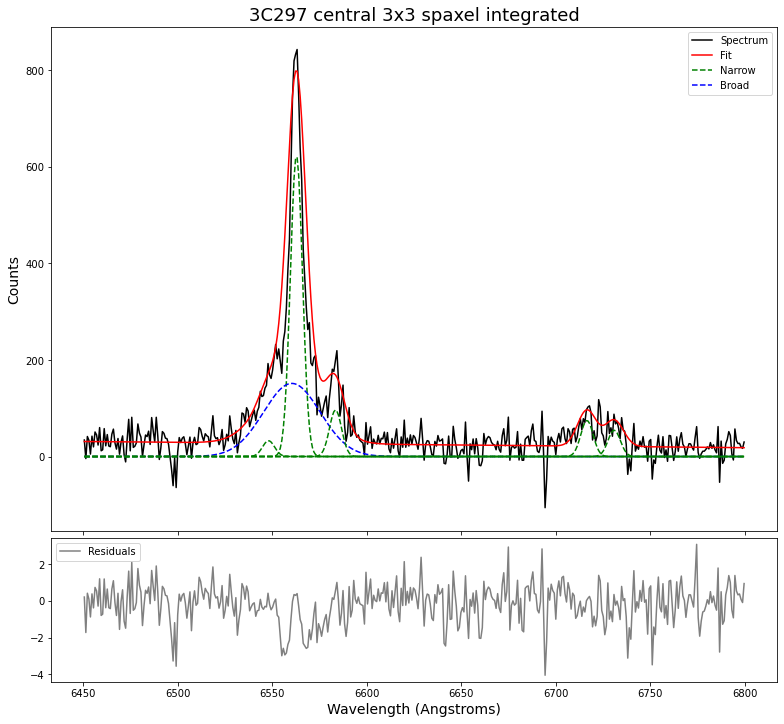

In [17]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
ax2 = fig.add_axes([0.1, 0.06, 0.84, 0.2]) # inset axes


(amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c) = pfit

def full_gauss(wave_range,amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c):
    Ha = gauss(wave_range,amp_Ha,vel,220,6562.8)
    Ha_broad = gauss(wave_range,amp_HaB,vel_HaB,vel_sigma_HaB, 6562.8)
    NII_6583 = gauss(wave_range,amp_NII6585,vel,220,6583.46)
    NII_6548 = (0.34)*gauss(wave_range,amp_NII6585,vel,220,6548.05) 
    SII_6716 = gauss(wave_range,amp_SII6716,vel,220,6716.4)
    SII_6730 = gauss(wave_range,amp_SII6730,vel,220,6730.8)
    cont = (wave_range/1000.0)*m+c
    return Ha + Ha_broad + NII_6548 + NII_6583 + SII_6716 + SII_6730 + cont

yfit = full_gauss(small_wave,amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c)
ax1.plot(small_wave, small_spec, 'k-', label='Spectrum')
ax1.plot(small_wave, yfit,'r-',label='Fit')
ax1.plot(small_wave, gauss(small_wave,amp_Ha,vel,vel_sigma,6562.8), 'g-', linestyle='--', label='Narrow')
ax1.plot(small_wave, gauss(small_wave,amp_HaB,vel_HaB,vel_sigma_HaB, 6562.8), 'b-', linestyle='--', label='Broad')
ax1.plot(small_wave, gauss(small_wave,amp_NII6585,vel,vel_sigma,6583.46), 'g-', linestyle='--')
ax1.plot(small_wave, (0.34)*gauss(small_wave,amp_NII6585,vel,vel_sigma,6548.05), 'g-', linestyle='--')
ax1.plot(small_wave, gauss(small_wave,amp_SII6716,vel,vel_sigma,6716.4), 'g-', linestyle='--')
ax1.plot(small_wave, gauss(small_wave,amp_SII6730,vel,vel_sigma,6730.8), 'g-', linestyle='--')
residuals = (small_spec - yfit)/err_spec
ax2.plot(small_wave, residuals, 'gray', label='Residuals')
plt.rcParams["figure.figsize"] = [12,10]
ax1.set_title('3C297 central 3x3 spaxel integrated', {'fontsize': 18})
ax1.set_ylabel('Counts', {'fontsize': 14})
ax2.set_xlabel('Wavelength (Angstroms)', {'fontsize': 14})
ax1.legend()
ax2.legend()
plt.show()

In [24]:
print (pcov)
#pcov or cov_x => The inverse of the Hessian. A value of None indicates a singular matrix, 
#which means the curvature in parameters x is numerically flat.
#To obtain the covariance matrix of the parameters x, cov_x must be multiplied by the variance of the residuals:
# r = f(xdata, *popt) - ydata

#pcov_fit = pcov*np.var(residuals)
#print(pcov_fit)


[[ 2.45903994e+03  1.34169237e+02  4.56179464e+01  3.51958941e+01
  -2.25525493e+01 -1.41618129e+02 -3.17643970e+02 -1.51427020e+02
   6.76319819e+02  2.67017144e+01 -1.78790061e+02]
 [ 1.34169237e+02  5.30279781e+02 -8.85483901e+00 -6.90318203e+00
   7.11002090e+00  2.48641968e+01 -1.11712613e+02 -4.86534483e+02
  -3.27674833e+02 -1.24592089e+01  8.42042759e+01]
 [ 4.56179464e+01 -8.85483901e+00  2.23652126e+02  1.29629378e+01
   4.06478974e+00 -3.74178857e+01  4.04594045e+01  5.66637786e+01
  -2.66539674e+01 -1.22164463e+01  7.91549086e+01]
 [ 3.51958941e+01 -6.90318203e+00  1.29629378e+01  1.28641135e+02
   2.01459228e+00 -2.87505392e+01  3.09469287e+01  4.62628021e+01
  -1.97569174e+01 -1.53995609e+01  1.00254564e+02]
 [-2.25525493e+01  7.11002090e+00  4.06478974e+00  2.01459228e+00
   1.00983635e+02 -2.13229062e+00  1.91592941e+01 -7.68602559e+01
  -6.45492779e+01 -1.27928538e+00  8.69471808e+00]
 [-1.41618129e+02  2.48641968e+01 -3.74178857e+01 -2.87505392e+01
  -2.13229062e+00  

In [25]:
#uncertainty in leastsq fit

s_sq = (full_gauss_residual(pfit, small_wave, small_spec, err_spec)**2).sum()/(len(small_spec)-len(x0))
pcov = pcov * s_sq

error = [] 
for i in range(len(pfit)):
    try:
        error.append(np.absolute(pcov[i][i])**0.5)
    except:
        error.append(0.00)

perr_leastsq = np.array(error) 
print(perr_leastsq)

[47.70599121 22.15351616 14.38721216 10.91138962  9.6675323  10.4753722
 20.09636174 53.78116265 53.23415876 11.25328724 74.8890789 ]


In [18]:
#error estimation using Monte-Carlo simulation

MonteCarlo_loops = 100
param_MC = np.zeros((len(pfit), MonteCarlo_loops)) 

for i in range(MonteCarlo_loops):
    iteration_data = np.random.normal(small_spec, err_spec)
    pfit_MC, pcov_MC = leastsq(full_gauss_residual, x0, args=(small_wave, iteration_data, err_spec), maxfev = 10000000) 
    param_MC[:,i] = pfit_MC
    
param_err = np.std(param_MC, axis=1)

print(pfit)
print(param_err)

[ 623.54137786   96.44634558   74.65722205   54.4865179     0.81614423
  145.7998057   151.39299291 -110.00085363  684.19311807  -36.62889007
  267.40596333]
[55.6540857  28.30552015 15.72078248 11.6607863  10.13509317 15.62964134
 27.61135417 65.56819574 86.38010887 10.21366995 67.98591913]


In [ ]:
#(amp_Ha_err,amp_NII6585_err,amp_SII6716_err,amp_SII6730_err,vel_err,
#         vel_sigma_err,amp_HaB_err,vel_HaB_err,vel_sigma_HaB_err,m_err,c_err) = param_err

In [ ]:
##### Testing fit by excluding the broad Ha component 

[639.04318513 150.92471258  57.89566825  37.65420638 -14.6833507
 227.53597583 -52.68210862 374.98127832]
number of function calls = 121


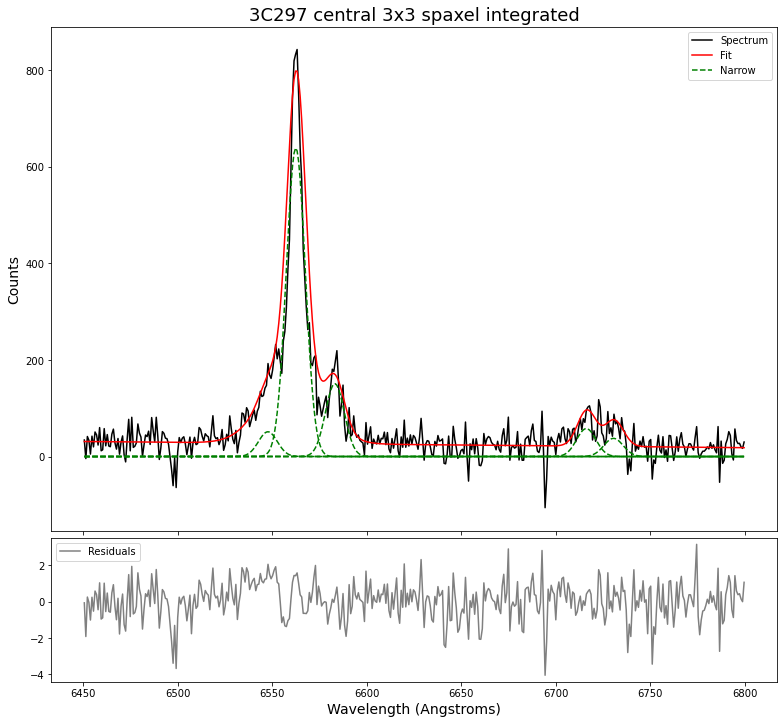

In [27]:
def full_gauss_residual2(params,wave_range,data,error):
    (amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,m,c) = params
    
    SII_6716 = gauss(wave_range,amp_SII6716,vel,vel_sigma,6716.4)
    SII_6730 = gauss(wave_range,amp_SII6730,vel,vel_sigma,6730.8)
    Ha = gauss(wave_range,amp_Ha,vel,vel_sigma,6562.8)
    #Ha_broad = gauss(wave_range,amp_HaB,vel_HaB,vel_sigma_HaB, 6562.8)
    NII_6583 = gauss(wave_range,amp_NII6585,vel,vel_sigma,6583.46)
    NII_6548 = (0.34)*gauss(wave_range,amp_NII6585,vel,vel_sigma,6548.05)    
    cont = (wave_range/1000.0)*m+c
    
    return ((Ha+NII_6548+NII_6583+SII_6716+SII_6730+cont)-data)/error
    
    
from scipy.optimize import leastsq
from numpy import asarray as ar,exp

x0 = [900, 200, 50, 50, 0, 100, 0, 10]
params = np.arange(8)

pfit2, pcov2, info2, msg2, success2 = leastsq(full_gauss_residual2, x0, args=(small_wave, small_spec, err_spec), 
                                              full_output=1, maxfev=10000000)

print(pfit2)
print('number of function calls =', info['nfev'])


fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
ax2 = fig.add_axes([0.1, 0.06, 0.84, 0.2]) # inset axes

(amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,m,c) = pfit2

def full_gauss2(wave_range,amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,m,c):
    Ha = gauss(wave_range,amp_Ha,vel,220,6562.8)
    NII_6583 = gauss(wave_range,amp_NII6585,vel,220,6583.46)
    NII_6548 = (0.34)*gauss(wave_range,amp_NII6585,vel,220,6548.05) 
    SII_6716 = gauss(wave_range,amp_SII6716,vel,220,6716.4)
    SII_6730 = gauss(wave_range,amp_SII6730,vel,220,6730.8)
    cont = (wave_range/1000.0)*m+c
    return Ha + NII_6548 + NII_6583 + SII_6716 + SII_6730 + cont

yfit2 = full_gauss2(small_wave,amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,m,c)
ax1.plot(small_wave, small_spec, 'k-', label='Spectrum')
ax1.plot(small_wave, yfit,'r-',label='Fit')
ax1.plot(small_wave, gauss(small_wave,amp_Ha,vel,vel_sigma,6562.8), 'g-', linestyle='--', label='Narrow')
ax1.plot(small_wave, gauss(small_wave,amp_NII6585,vel,vel_sigma,6583.46), 'g-', linestyle='--')
ax1.plot(small_wave, (0.34)*gauss(small_wave,amp_NII6585,vel,vel_sigma,6548.05), 'g-', linestyle='--')
ax1.plot(small_wave, gauss(small_wave,amp_SII6716,vel,vel_sigma,6716.4), 'g-', linestyle='--')
ax1.plot(small_wave, gauss(small_wave,amp_SII6730,vel,vel_sigma,6730.8), 'g-', linestyle='--')
residuals = (small_spec - yfit2)/err_spec
ax2.plot(small_wave, residuals, 'gray', label='Residuals')
plt.rcParams["figure.figsize"] = [12,10]
ax1.set_title('3C297 central 3x3 spaxel integrated', {'fontsize': 18})
ax1.set_ylabel('Counts', {'fontsize': 14})
ax2.set_xlabel('Wavelength (Angstroms)', {'fontsize': 14})
ax1.legend()
ax2.legend()
plt.show()

# amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,m,c